In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree, ConvexHull

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

from helpers import fig_path

In [2]:
cmap = mpl.colors.ListedColormap(center_emph.colors[16:-16])

Using same values from Patel et al.

In [3]:
vsun = coord.CartesianDifferential([11.1, 251.24, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, galcen_v_sun=vsun)

Convert gas velocity from LSR back to Barycentric:

In [7]:
_gal = coord.SkyCoord(ra=178.8*u.deg, dec=-29.4*u.deg).galactic
l = _gal.l
b = _gal.b

vlsrs = [60, 110., 230, 270] * u.km/u.s
nlsr = len(vlsrs)

In [8]:
c = coord.SkyCoord(ra=[178.8]*nlsr*u.deg, dec=[-29.4]*nlsr*u.deg, 
                   distance=[29]*nlsr*u.kpc,
                   pm_ra_cosdec=[-0.56]*u.mas/u.yr, 
                   pm_dec=[0.47]*u.mas/u.yr,
                   radial_velocity=vlsrs,
                   frame='lsr')
c = c.transform_to(coord.ICRS)

In [9]:
galcen = c.transform_to(coord.Galactocentric)
galcen.velocity.norm(), galcen.velocity.d_z

(<Quantity [193.94818504, 168.53158633, 163.3759121 , 180.3365918 ] km / s>,
 <Quantity [ 68.39169245,  94.7626387 , 158.05290969, 179.14966669] km / s>)

In [10]:
galcen[0].represent_as(coord.CylindricalRepresentation)

<CylindricalRepresentation (rho, phi, z) in (kpc, rad, kpc)
    (23.35473801, -1.58956165, 15.32214882)
 (has differentials w.r.t.: 's')>

In [11]:
pot = gp.MilkyWayPotential()

cl_w0 = gd.PhaseSpacePosition(galcen.cartesian)
lmc_w0 = gd.PhaseSpacePosition(pos=[-1.1, -41.1, -27.9] * u.kpc,
                               vel=[-57., -226, 221] * u.km/u.s)

In [14]:
# NO LMC
cl_orbit = pot.integrate_orbit(cl_w0, dt=-1, n_steps=300)
lmc_orbit = pot.integrate_orbit(lmc_w0, dt=-1, n_steps=300)
lmc_orbit_fut = pot.integrate_orbit(lmc_w0, dt=1, n_steps=300)

# --------------------------------------------------

# WITH LMC

# From Erkal Tuc III paper
# lmc_M = 10e10 * u.Msun
# lmc_rs = 12.40 * u.kpc
# lmc_M = 25e10 * u.Msun
# lmc_rs = 24.66 * u.kpc
# lmc_M = 80e10 * u.Msun
# lmc_rs = 25. * u.kpc

# def F(t, w):
#     x, y, z, vx, vy, vz = w
    
#     q = np.vstack([x, y, z])
#     p = np.vstack([vx, vy, vz])
    
#     acc = pot.acceleration(q)
    
#     # subhalo
#     lmc = gp.HernquistPotential(m=lmc_M, c=lmc_rs, 
#                                 units=galactic, origin=q[:, 0])
#     lmc_acc = lmc.acceleration(q[:, 1:])
#     acc[:, 1:] = acc[:, 1:] + lmc_acc
    
#     return np.vstack((p, acc.value))

# integrator = gi.LeapfrogIntegrator(F, func_units=galactic)
# all_w0 = gd.combine((lmc_w0, cl_w0))
# orbits = integrator.run(all_w0, dt=-1, n_steps=1000)
# cl_orbit = orbits[:, 1:]
# lmc_orbit = orbits[:, 0]

Text(-70,-60,'LMC past')

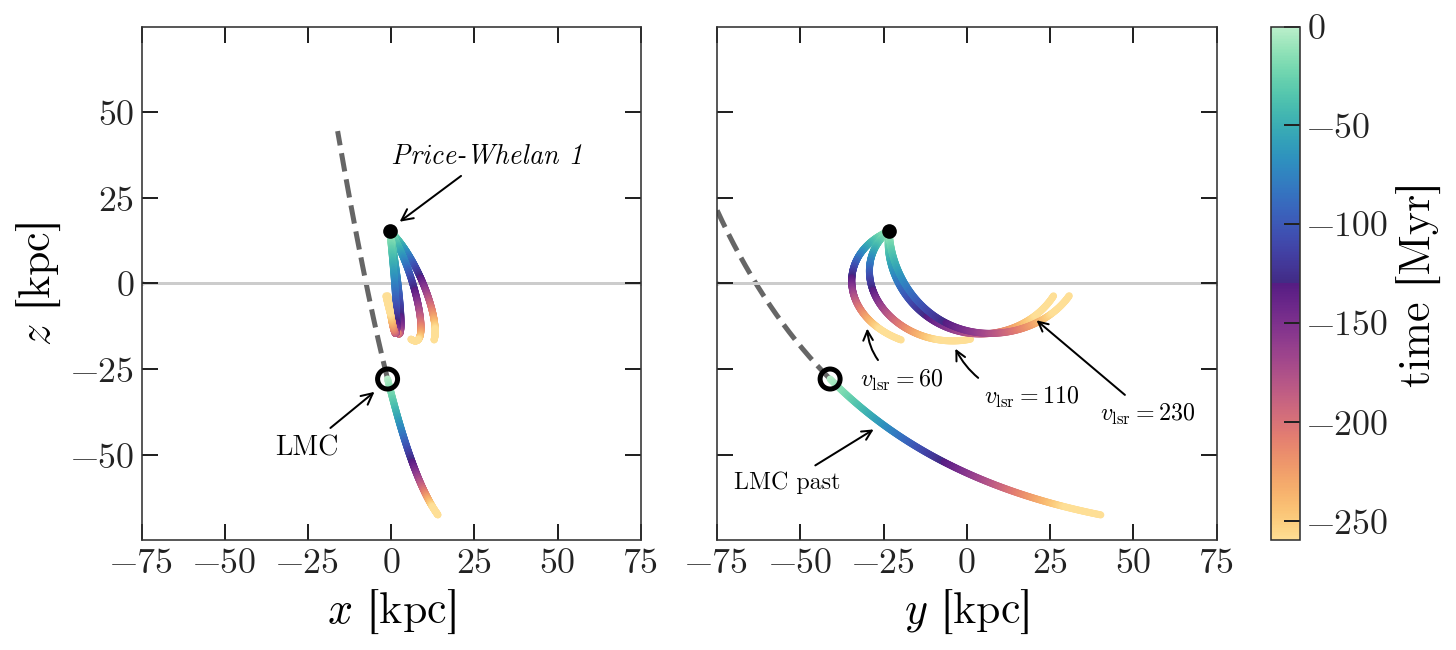

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.4),
                         constrained_layout=True, 
                         sharex=True, sharey=True)

style = dict(c=cl_orbit.t.value, marker='.',
             vmin=-260, vmax=0, cmap=cmap)
for i in range(len(vlsrs)):
    _cs = axes[0].scatter(cl_orbit.x[:, i], cl_orbit.z[:, i], **style)
    _cs = axes[1].scatter(cl_orbit.y[:, i], cl_orbit.z[:, i], **style)

axes[0].scatter(cl_w0.x[0], cl_w0.z[0], 
                marker='o', color='k',
                s=40, zorder=100)
axes[1].scatter(cl_w0.y[0], cl_w0.z[0], 
                marker='o', color='k',
                s=40, zorder=100)
    
# circ = mpl.patches.Circle((lmc_w0.x.value, lmc_w0.z.value),
#                           radius=lmc_rs.value/ 2.,
#                           facecolor='none', edgecolor='k', 
#                           linewidth=2.5,
#                           zorder=100)
# axes[0].add_patch(circ)
axes[0].scatter(lmc_w0.x.value, lmc_w0.z.value,
                marker='o', edgecolor='k', linewidth=2.5,
                s=100, zorder=100, facecolor='none')
axes[1].scatter(lmc_w0.y, lmc_w0.z, 
                marker='o', edgecolor='k', linewidth=2.5,
                s=100, zorder=100, facecolor='none')

axes[0].scatter(lmc_orbit.x, lmc_orbit.z,
                c=lmc_orbit.t.value, marker='.',
                vmin=-260, vmax=0, cmap=cmap)
axes[1].scatter(lmc_orbit.y, lmc_orbit.z,
                c=lmc_orbit.t.value, marker='.',
                vmin=-260, vmax=0, cmap=cmap)
    
axes[0].plot(lmc_orbit_fut.x, lmc_orbit_fut.z,
             ls='--', marker='', color='#666666', 
             zorder=-100, lw=2.5)
axes[1].plot(lmc_orbit_fut.y, lmc_orbit_fut.z,
             ls='--', marker='', color='#666666', 
             zorder=-100, lw=2.5)

ax = axes[0]
ax.set_xlim(-75, 75)
ax.set_ylim(-75, 75)

for ax in axes:
    ax.xaxis.set_ticks(np.arange(-75, 75+1, 25))
    ax.yaxis.set_ticks(np.arange(-75, 75+1, 25))
    ax.axhline(0, zorder=-100, color='#cccccc')

axes[0].set_xlabel('$x$ [kpc]')
axes[0].set_ylabel('$z$ [kpc]')
axes[1].set_xlabel('$y$ [kpc]')

cb = fig.colorbar(_cs, ax=axes, aspect=40)
cb.set_label('time [Myr]')

ax.set_yticks(np.arange(-50, 50+1, 25))

# Annotation
axes[0].annotate(xy=(lmc_w0.x.value-3., lmc_w0.z.value-3), 
                 xytext=(-35, -50), 
                 s=r'LMC', fontsize=14, 
                 arrowprops=dict(color='black', arrowstyle='->'))
axes[0].annotate(xy=(cl_w0.x.value[0]+2., cl_w0.z.value[0]+2), 
                 xytext=(0, 35), 
                 s=r'Price-Whelan 1', fontsize=14, fontstyle='italic',
                 arrowprops=dict(color='black', arrowstyle='->'))

ax = axes[1]
ax.annotate(xy=(20, -10), xytext=(40, -40), 
            s=r'$v_{\rm lsr} = ' + '{0:.0f}$'.format(vlsrs[2].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->'))
ax.annotate(xy=(-4, -18), xytext=(5, -35), 
            s=r'$v_{\rm lsr} = ' + '{0:.0f}$'.format(vlsrs[1].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->', connectionstyle="arc3,rad=-0.3"))
ax.annotate(xy=(-30, -12), xytext=(-32, -30), 
            s=r'$v_{\rm lsr} = ' + '{0:.0f}$'.format(vlsrs[0].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->', connectionstyle="arc3,rad=-0.3"))

ax.annotate(xy=(-27, -42), xytext=(-70, -60), 
            s=r'LMC past'.format(vlsrs[0].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->'))

# fig.savefig(fig_path / 'orbits.pdf')

In [114]:
lmcE = lmc_orbit.energy()[0]
dE = lmcE - cl_orbit.energy()[0]
print((dE/lmcE).decompose())
dE.to(u.km/u.s * u.kpc/u.Myr)

[-2.56917731 -2.79122586 -2.85066088]


<Quantity [ 56.60367643, 61.49581233, 62.80527442] km kpc / (Myr s)>

---

In [32]:
cyl = cl_orbit.represent_as(coord.CylindricalRepresentation)
lmc_cyl = lmc_w0.represent_as(coord.CylindricalRepresentation)
lmc_past_cyl = lmc_orbit.represent_as(coord.CylindricalRepresentation)
lmc_fut_cyl = lmc_orbit_fut.represent_as(coord.CylindricalRepresentation)

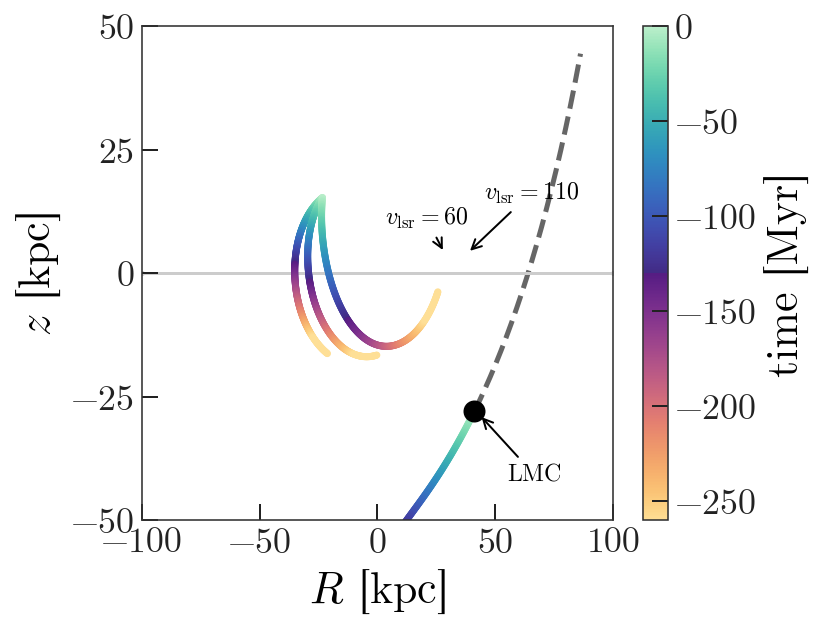

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5.8, 4.5))

for i in range(3):
#     _cs = ax.scatter(cyl.rho[:, i], cyl.z[:, i], 
#                      c=cl_orbit.t.value, marker='.',
#                      vmin=-260, vmax=0, cmap=cmap)
    _cs = ax.scatter(cl_orbit.y[:, i], cyl.z[:, i], 
                     c=cl_orbit.t.value, marker='.',
                     vmin=-260, vmax=0, cmap=cmap)

ax.scatter(lmc_cyl.rho, lmc_cyl.z, 
           marker='o', color='k', 
           s=100, zorder=100)

ax.scatter(lmc_past_cyl.rho, lmc_past_cyl.z,
           c=lmc_orbit.t.value, marker='.',
           vmin=-260, vmax=0, cmap=cmap)
    
ax.plot(lmc_fut_cyl.rho, lmc_fut_cyl.z,
        ls='--', marker='', color='#666666', 
        zorder=-100, lw=2.5)
    
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 50)

ax.axhline(0, zorder=-100, color='#cccccc')

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

cb = fig.colorbar(_cs)
cb.set_label('time [Myr]')

ax.set_yticks(np.arange(-50, 50+1, 25))

# Annotation
ax.annotate(xy=(38, 4), xytext=(45, 15), 
            s=r'$v_{\rm lsr} = ' + '{0:.0f}$'.format(vlsrs[1].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->'))
ax.annotate(xy=(28.5, 4), xytext=(3, 10), 
            s=r'$v_{\rm lsr} = ' + '{0:.0f}$'.format(vlsrs[0].value), 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->'))
ax.annotate(xy=(43., -28.5), xytext=(55, -42), 
            s=r'LMC', 
            fontsize=12, arrowprops=dict(color='black', arrowstyle='->'))


fig.tight_layout()
# fig.savefig(fig_path / 'orbits.pdf')

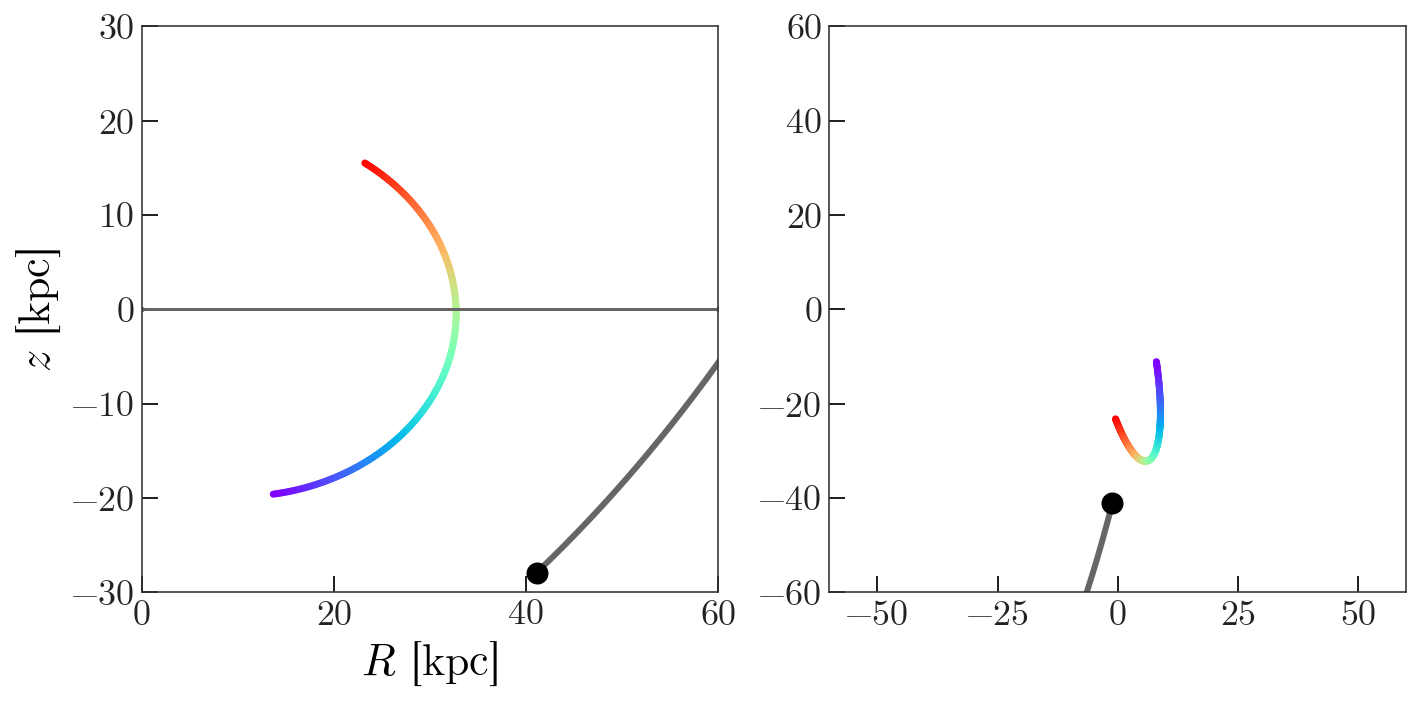

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
_cs = ax.scatter(cyl.rho, cyl.z, 
                 c=cl_orbit.t.value, marker='.',
                 cmap='rainbow')

ax.scatter(lmc_cyl.rho, lmc_cyl.z, 
           marker='o', color='k', 
           s=100, zorder=100)
    
ax.plot(lmc_fut_cyl.rho, lmc_fut_cyl.z,
        ls='-', marker='', color='#666666', 
        zorder=-100, lw=3)
    
ax.set_xlim(0, 60)
ax.set_ylim(-30, 30)

ax.axhline(0)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

# cb = fig.colorbar(_cs)
# cb.set_label('time [Myr]')

# ---

ax = axes[1]
_cs = ax.scatter(cl_orbit.x, cl_orbit.y, 
                 c=cl_orbit.t.value, marker='.',
                 cmap='rainbow')

ax.scatter(lmc_w0.x, lmc_w0.y, 
           marker='o', color='k', 
           s=100, zorder=100)
    
ax.plot(lmc_orbit_fut.x, lmc_orbit_fut.y,
        ls='-', marker='', color='#666666', 
        zorder=-100, lw=3)

ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)

fig.tight_layout()

In [51]:
dE = lmc_w0.energy(gp.Hamiltonian(pot))[:] - cl_w0.energy(gp.Hamiltonian(pot))[:]
dE.to(u.km/u.s * u.kpc/u.Myr)

<Quantity [ 55.61088162, 59.56368485] km kpc / (Myr s)>

(-200, 200)

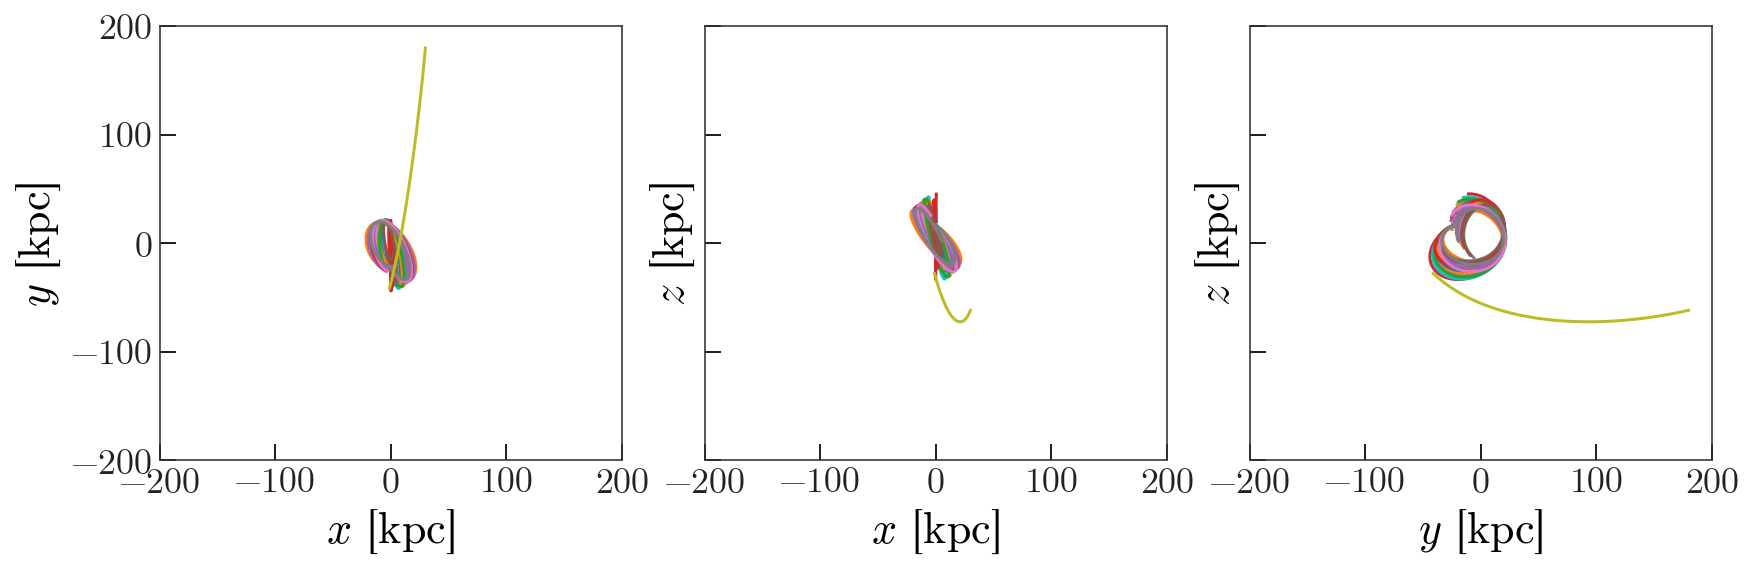

In [70]:
fig = cl_orbit.plot(auto_aspect=False, subplots_kwargs=dict(sharex=True, sharey=True))
_ = lmc_orbit.plot(auto_aspect=False, axes=fig.axes)

fig.axes[0].set_xlim(-200, 200)
fig.axes[0].set_ylim(-200, 200)

Compare longitude-distance to http://iopscience.iop.org/article/10.3847/1538-4357/835/2/285/meta Figure 16

In [140]:
cl_mag = cl_orbit.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)
lmc_mag = lmc_orbit_fut.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)

Text(0,0.5,'distance [kpc]')

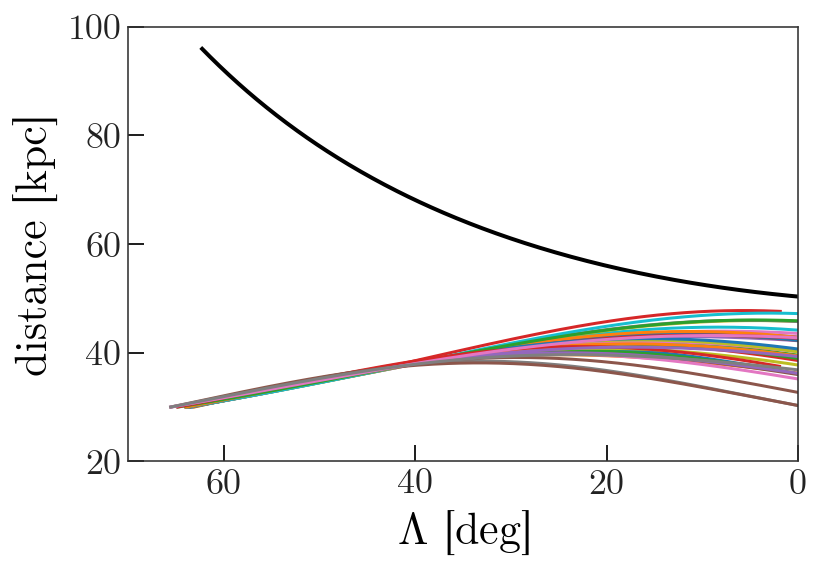

In [148]:
plt.plot(cl_mag.L.wrap_at(180*u.deg).degree,
         cl_mag.distance, marker='')

plt.plot(lmc_mag.L.wrap_at(180*u.deg).degree,
         lmc_mag.distance, 
         marker='', color='k', lw=2)

plt.xlim(70, 0)
plt.ylim(20, 100)
plt.xlabel(r'$\Lambda$ [deg]')
plt.ylabel(r'distance [kpc]')